Setup

In [34]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [35]:
from google.colab import drive
drive.mount('/content/drive')
dataset = ImageFolder('/content/drive/My Drive/CSC420/DBI')
#dataset = ImageFolder('/content/drive/My Drive/CSC420/SDD')
print(len(dataset))
print(len(dataset.classes))

breeds = []

for n in dataset.classes:
    print(n)
    breeds.append(n)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
646
7
bernese_mountain_dog
border_collie
chihuahua
golden_retriever
labrador_retriever
pug
siberian_husky


**Generate random training/validation/testing datasets from data**

In [36]:
random_seed = 45
torch.manual_seed(random_seed);
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


print(train_size, val_size, test_size)
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

408 45 193


(408, 45, 193)

golden_retriever
<class 'PIL.Image.Image'>


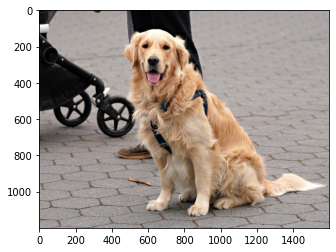

In [37]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

# **Creating Custom Dataset**
To create our custom Dataset, we need to extend Pytorch's `Dataset` class.
We need to implement 3 methods inside our Custom Dataset Class:

1. `__init__`
2. `__len__`
3. `__getitem__`

3


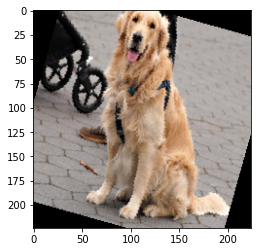

In [38]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

## now we see our training sets

img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [39]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [7]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
show_batch(train_dl)

KeyboardInterrupt: ignored

In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_accuracy: {:.4f}, val_accuracy: {:.4f}, test_accuracy: {:.4f}".format(epoch, result['train']["val_acc"], result['val']["val_acc"], result['test']["val_acc"]))



In [9]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.BatchNorm2d(16),                                   
            nn.Conv2d(16, 16, 3, stride=1, padding=1),    
            nn.MaxPool2d(2, 2),                         
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.MaxPool2d(2,2),                          
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.ReLU(),
            nn.Softmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [10]:
model = DogBreedClassificationCNN()
model

DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=25088, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=7, bias=True)
    (13): ReLU()
    (14): Softmax(dim=1)
  )
)

In [41]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [42]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [43]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)



# moving model to gpu
to_device(model, device);

cuda


In [14]:
from tqdm.notebook import tqdm

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        train_history = []
        validation_history = []
        test_history = []

        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        
        result = {}
        result['train'] = evaluate(model, train_loader)
        result['val'] = evaluate(model, val_loader)
        result['test'] = evaluate(model, test_loader)

        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [16]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_accuracy: 0.1957, val_accuracy: 0.2444, test_accuracy: 0.1592


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_accuracy: 0.2664, val_accuracy: 0.2444, test_accuracy: 0.1901


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_accuracy: 0.2976, val_accuracy: 0.2667, test_accuracy: 0.2522


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_accuracy: 0.3214, val_accuracy: 0.3556, test_accuracy: 0.2447


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_accuracy: 0.3534, val_accuracy: 0.3333, test_accuracy: 0.2598


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_accuracy: 0.3415, val_accuracy: 0.3333, test_accuracy: 0.2909


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_accuracy: 0.3958, val_accuracy: 0.4000, test_accuracy: 0.3066


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_accuracy: 0.4062, val_accuracy: 0.4000, test_accuracy: 0.3184


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_accuracy: 0.4368, val_accuracy: 0.4222, test_accuracy: 0.3338


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_accuracy: 0.4338, val_accuracy: 0.4444, test_accuracy: 0.3183


In [ ]:
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_acc.append(h['val']['val_acc'])
    train_acc.append(h['train']['val_acc'])
    test_acc.append(h['test']['val_acc'])


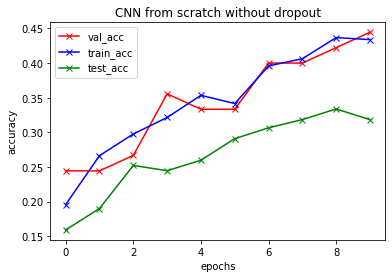

In [ ]:
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.plot(time, test_acc, c='green', label='test_acc', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('CNN from scratch without dropout')
plt.show()

In [ ]:
class DogBreedClassificationCNNWithDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.BatchNorm2d(16),                                   
            nn.Conv2d(16, 16, 3, stride=1, padding=1),    
            nn.MaxPool2d(2, 2),                         
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.MaxPool2d(2,2),                          
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Softmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
dropout = DogBreedClassificationCNNWithDropout()
dropout
to_device(dropout, device);

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, dropout, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_accuracy: 0.1548, val_accuracy: 0.2000, test_accuracy: 0.1432


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_accuracy: 0.1555, val_accuracy: 0.2000, test_accuracy: 0.1160


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_accuracy: 0.1875, val_accuracy: 0.1778, test_accuracy: 0.1936


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_accuracy: 0.3229, val_accuracy: 0.3111, test_accuracy: 0.2674


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_accuracy: 0.3132, val_accuracy: 0.2889, test_accuracy: 0.2635


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_accuracy: 0.3899, val_accuracy: 0.2222, test_accuracy: 0.2948


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_accuracy: 0.3631, val_accuracy: 0.2667, test_accuracy: 0.2793


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_accuracy: 0.3929, val_accuracy: 0.2889, test_accuracy: 0.2831


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_accuracy: 0.4271, val_accuracy: 0.3111, test_accuracy: 0.2754


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_accuracy: 0.4167, val_accuracy: 0.2667, test_accuracy: 0.2755


In [ ]:
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_acc.append(h['val']['val_acc'])
    train_acc.append(h['train']['val_acc'])
    test_acc.append(h['test']['val_acc'])


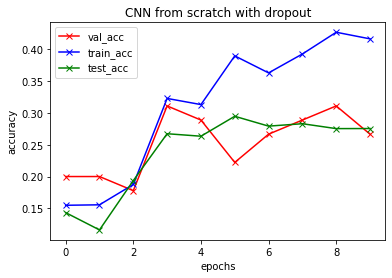

In [ ]:
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.plot(time, test_acc, c='green', label='test_acc', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('CNN from scratch with dropout')
plt.show()

In [17]:
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
resnet18 = DogBreedResnet18()
resnet18

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DogBreedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [19]:
to_device(resnet18, device);

In [20]:
history = fit_one_cycle(num_epochs, max_lr, resnet18, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [0] : train_accuracy: 0.1962, val_accuracy: 0.1977, test_accuracy: 0.1512


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1] : train_accuracy: 0.1921, val_accuracy: 0.1977, test_accuracy: 0.1560


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2] : train_accuracy: 0.1983, val_accuracy: 0.2209, test_accuracy: 0.2151


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3] : train_accuracy: 0.2538, val_accuracy: 0.1977, test_accuracy: 0.2102


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4] : train_accuracy: 0.2507, val_accuracy: 0.2093, test_accuracy: 0.2199


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5] : train_accuracy: 0.3803, val_accuracy: 0.2907, test_accuracy: 0.3058


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6] : train_accuracy: 0.3413, val_accuracy: 0.2791, test_accuracy: 0.2532


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7] : train_accuracy: 0.3877, val_accuracy: 0.3372, test_accuracy: 0.3557


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8] : train_accuracy: 0.4382, val_accuracy: 0.3488, test_accuracy: 0.3593


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9] : train_accuracy: 0.4623, val_accuracy: 0.4186, test_accuracy: 0.3893


In [21]:
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_acc.append(h['val']['val_acc'])
    train_acc.append(h['train']['val_acc'])
    test_acc.append(h['test']['val_acc'])

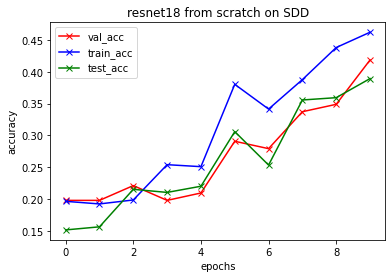

In [22]:
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.plot(time, test_acc, c='green', label='test_acc', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('resnet18 from scratch on SDD')
plt.show()

In [23]:
class PretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        # Replace last layer
        for param in self.network.parameters():
          param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [24]:
presnet18 = PretrainedResnet18()
to_device(presnet18, device);

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [25]:
history = fit_one_cycle(num_epochs, max_lr, presnet18, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [0] : train_accuracy: 0.2531, val_accuracy: 0.2674, test_accuracy: 0.2666


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1] : train_accuracy: 0.7019, val_accuracy: 0.7093, test_accuracy: 0.6884


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2] : train_accuracy: 0.8937, val_accuracy: 0.8721, test_accuracy: 0.8787


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3] : train_accuracy: 0.9226, val_accuracy: 0.9070, test_accuracy: 0.8953


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4] : train_accuracy: 0.9267, val_accuracy: 0.9302, test_accuracy: 0.9038


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5] : train_accuracy: 0.9447, val_accuracy: 0.9186, test_accuracy: 0.9195


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6] : train_accuracy: 0.9418, val_accuracy: 0.9070, test_accuracy: 0.8882


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7] : train_accuracy: 0.9591, val_accuracy: 0.9070, test_accuracy: 0.9142


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8] : train_accuracy: 0.9459, val_accuracy: 0.9070, test_accuracy: 0.9201


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9] : train_accuracy: 0.9498, val_accuracy: 0.9186, test_accuracy: 0.9149


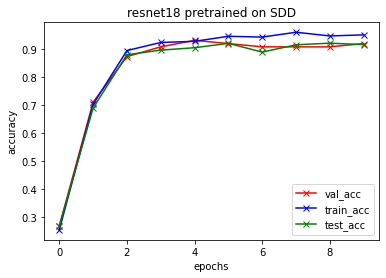

In [27]:
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_acc.append(h['val']['val_acc'])
    train_acc.append(h['train']['val_acc'])
    test_acc.append(h['test']['val_acc'])
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.plot(time, test_acc, c='green', label='test_acc', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('resnet18 pretrained on SDD')
plt.show()

In [28]:
class PretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(weights='ResNet34_Weights.DEFAULT')
        # Replace last layer
        for param in self.network.parameters():
          param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

presnet34 = PretrainedResnet34()
to_device(presnet34, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [29]:
history = fit_one_cycle(num_epochs, max_lr, presnet34, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [0] : train_accuracy: 0.2964, val_accuracy: 0.3837, test_accuracy: 0.2545


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1] : train_accuracy: 0.8474, val_accuracy: 0.8140, test_accuracy: 0.8207


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2] : train_accuracy: 0.9346, val_accuracy: 0.8837, test_accuracy: 0.9332


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3] : train_accuracy: 0.9238, val_accuracy: 0.9186, test_accuracy: 0.9228


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4] : train_accuracy: 0.9639, val_accuracy: 0.8953, test_accuracy: 0.9172


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5] : train_accuracy: 0.9507, val_accuracy: 0.9070, test_accuracy: 0.9410


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6] : train_accuracy: 0.9575, val_accuracy: 0.9070, test_accuracy: 0.9201


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7] : train_accuracy: 0.9651, val_accuracy: 0.9070, test_accuracy: 0.9358


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8] : train_accuracy: 0.9724, val_accuracy: 0.9070, test_accuracy: 0.9309


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9] : train_accuracy: 0.9772, val_accuracy: 0.9070, test_accuracy: 0.9335


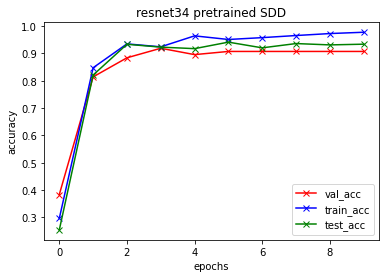

In [30]:
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_acc.append(h['val']['val_acc'])
    train_acc.append(h['train']['val_acc'])
    test_acc.append(h['test']['val_acc'])
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.plot(time, test_acc, c='green', label='test_acc', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('resnet34 pretrained SDD')
plt.show()

In [45]:
class PretrainedResnext32(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.DEFAULT')
        # Replace last layer
        for param in self.network.parameters():
          param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

presnext32 = PretrainedResnext32()
to_device(presnext32, device);

In [46]:
history = fit_one_cycle(num_epochs, max_lr, presnext32, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_accuracy: 0.3326, val_accuracy: 0.2889, test_accuracy: 0.3368


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_accuracy: 0.9345, val_accuracy: 0.9333, test_accuracy: 0.9419


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_accuracy: 0.9717, val_accuracy: 0.9778, test_accuracy: 0.9884


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_accuracy: 0.9821, val_accuracy: 1.0000, test_accuracy: 0.9883


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_accuracy: 0.9754, val_accuracy: 0.9778, test_accuracy: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_accuracy: 0.9866, val_accuracy: 0.9778, test_accuracy: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_accuracy: 0.9844, val_accuracy: 0.9778, test_accuracy: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_accuracy: 0.9829, val_accuracy: 0.9778, test_accuracy: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_accuracy: 0.9807, val_accuracy: 0.9778, test_accuracy: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_accuracy: 0.9933, val_accuracy: 0.9778, test_accuracy: 0.9805


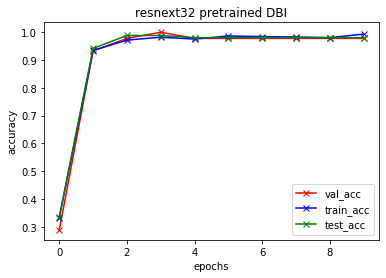

In [47]:
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_acc.append(h['val']['val_acc'])
    train_acc.append(h['train']['val_acc'])
    test_acc.append(h['test']['val_acc'])
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.plot(time, test_acc, c='green', label='test_acc', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('resnext32 pretrained DBI')
plt.show()

In [ ]:
dataset = ImageFolder('/content/drive/My Drive/CSC420/sdd_dbi')
print(len(dataset))
print(len(dataset.classes))

origins = []

for n in dataset.classes:
    print(n)
    origins.append(n)

1879
2
dbi
sdd


In [ ]:
random_seed = 45
torch.manual_seed(random_seed);
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


print(train_size, val_size, test_size)
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

1185 131 563


(1185, 131, 563)

dbi
<class 'PIL.Image.Image'>


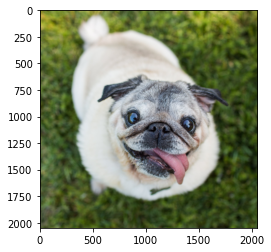

In [ ]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

0


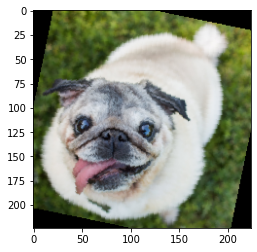

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

## now we see our training sets

img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Here, we choose to use the pretrained resnet18 as it was the best performing model when we tested on the DBI dataset.

In [49]:
class PretrainedResnet18SDDDBI(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        # Replace last layer
        for param in self.network.parameters():
          param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [50]:
presnet18_sdddbi = PretrainedResnet18SDDDBI()
print(device);
to_device(presnet18_sdddbi, device);
print(presnet18_sdddbi)

cuda
PretrainedResnet18SDDDBI(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, presnet18_sdddbi, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_accuracy: 0.6289, val_accuracy: 0.6419, test_accuracy: 0.6263


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_accuracy: 0.7677, val_accuracy: 0.8555, test_accuracy: 0.7443


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_accuracy: 0.8111, val_accuracy: 0.8906, test_accuracy: 0.8053


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_accuracy: 0.8284, val_accuracy: 0.7201, test_accuracy: 0.8186


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_accuracy: 0.8266, val_accuracy: 0.7318, test_accuracy: 0.8069


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_accuracy: 0.8349, val_accuracy: 0.8945, test_accuracy: 0.7873


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_accuracy: 0.8376, val_accuracy: 0.7318, test_accuracy: 0.8249


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_accuracy: 0.8422, val_accuracy: 0.7357, test_accuracy: 0.8249


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_accuracy: 0.8384, val_accuracy: 0.7396, test_accuracy: 0.8155


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_accuracy: 0.8505, val_accuracy: 0.7435, test_accuracy: 0.8100


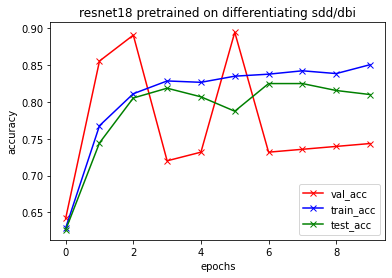

In [ ]:
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_acc.append(h['val']['val_acc'])
    train_acc.append(h['train']['val_acc'])
    test_acc.append(h['test']['val_acc'])
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.plot(time, test_acc, c='green', label='test_acc', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('resnet18 pretrained on differentiating sdd/dbi')
plt.show()

The validation set is relatively small, which could cause unexpected behaviours as seen on the spikes in the graph above.